In [117]:
import numpy as np
import cv2, math, time
from matplotlib import pyplot as plt

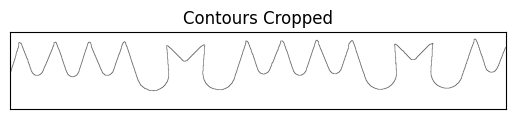

In [118]:
img = cv2.imread("Images\saw_01.png", 0)

ret,img_thresholded = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

kernel = np.ones((3,3),np.uint8)
img_contours = img_thresholded - cv2.erode(img_thresholded, kernel)     # Contours are white, background is black
img_contours_negative = 255 - img_contours                              # Contours are black, background is white

img_cc = img_contours_negative[400:600,:]
plt.imshow(img_cc, cmap = 'gray')
plt.title('Contours Cropped')
plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite("Images\saw_01_contours_cropped.png", img_cc)
raw_contour = [[i,j] for i in range(img_cc.shape[0]) for j in range(img_cc.shape[1]) if img_cc[i,j] == 0]

In [119]:
## Gif of the contours being drawn, order of the points drawn is the order of the list raw_contours (from top to bottom)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in raw_contours:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [126]:
def sort_contour_points(points, neighborhood_dimension):
    sorted_points = sorted(points, key=lambda p: p[1])
    
    sorted_contour = [sorted_points[0]]
    sorted_points.remove(sorted_points[0])    
    
    work_point = sorted_contour[0]

    while sorted_points:
        if len(sorted_points) > neighborhood_dimension:
            euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points[:neighborhood_dimension]]
        else:
            euclidean_distances = [((work_point[0] - p[0]) ** 2 + (work_point[1] - p[1]) ** 2) for p in sorted_points]    

        min_distance = min(euclidean_distances)
        nearest_neighbors = [i for i in range(len(euclidean_distances)) if euclidean_distances[i] == min_distance]

        work_point = sorted_points[nearest_neighbors[0]]

        for i in nearest_neighbors:
            sorted_contour.append(sorted_points[i])

        for i in sorted(nearest_neighbors, reverse=True):
            sorted_points.remove(sorted_points[i])
            
    return sorted_contour

'''
Why has been necessary to sort the points of the contour?
    - The contour is a list of points that are not ordered in any way, so the first step is to order them in a way that
    makes sense. The order of the points is important because it will be used to calculate the angle between each pair of
    points, and the angle is the most important feature of the contour.
Why has been necessary to use the euclidean distance to sort the points?
    - The euclidean distance is used to find the nearest neighbor of a point, and it is used because it is the most
    straightforward way to find the nearest neighbor of a point in a 2D space.
Why has been necessary to use the nearest neighbors?
    - Because the nearest neighbors of a point are the next points in the contour, and it is important to find the nearest
    neighbors of a point to order the contour. 
'''

sorted_contour = sort_contour_points(raw_contour, neighborhood_dimension=120)

In [121]:
# Gif of the contours being drawn, order of the points drawn is the order of the list sorted_contour (from left to right)
#blank = np.ones((img_cc.shape[0], img_cc.shape[1]), np.uint8) * 255
#for i in sorted_contour:
#    blank[i[0], i[1]] = 0
#    cv2.imshow('image', blank)
#    cv2.waitKey(1)
#
#cv2.waitKey(0)    
#cv2.destroyAllWindows()

In [122]:
def RDP_Algorithm(points, epsilon):
    # get the start and end points
    start = points[0]
    end = points[-1]

    # find distance from other points to line formed by start and end
    dist_point_to_line = DPTL(points, start, end)

    # get the index of the points with the largest distance
    max_value = max(dist_point_to_line)
    max_idx = dist_point_to_line.index(max_value) + 1 #since the first (and the last point) are not included in the calculation

    result = []
    if max_value > epsilon:
        if len(points[:max_idx+1]) == 2:
            result += [list(i) for i in points[:max_idx+1] if list(i) not in result]
        else:
            partial_results_left = RDP_Algorithm(points[:max_idx+1], epsilon)
            result += [list(i) for i in partial_results_left if list(i) not in result]
        if len(points[max_idx:]) == 2:
            result += [list(i) for i in points[max_idx:] if list(i) not in result]
        else:
            partial_results_right = RDP_Algorithm(points[max_idx:], epsilon)
            result += [list(i) for i in partial_results_right if list(i) not in result]
    else:
        result += [points[0], points[-1]]
    
    return result

def DPTL(points, start, end):
    # return a list of distances: distance of each point in points to line formed by start and end

    # compute the angular coefficient and the constant of the line formed by start and end
    # y - mx - q = 0
    a = start[1] - end[1]
    b = end[0] - start[0]
    c = - a*start[0] - b*start[1] 

    return [abs(a*points[i][0]+b*points[i][1]+c)/(math.sqrt(a**2+b**2)) for i in range(1,len(points))]

In [123]:
simplified_contour = RDP_Algorithm(sorted_contour, epsilon = 3)
# print them on a blank image
#blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
#for i in simplified_contour:
#    blank[i[0], i[1]] = [0,0,255]
#cv2.imwrite("Images\saw_01_simplified_contour.png", blank)

def distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

def segment_contours(points, threshold, min_points):
    segments = []
    i = 0
    while i < len(points):
        close_points = [points[i]]
        for j in range(i,len(points)-1):
            if distance(points[j], points[j+1]) < threshold:
                close_points.append(points[j+1])
            else:
                break
        if len(close_points) >= min_points:
            segments.append(close_points)
            i += len(close_points)
        else:
            segments.append([points[i]])
            i += 1
    return segments

def extract_circular_arcs(segement_points, sorted_contour):
    circular_arcs = []
    for i in segement_points:
        if len(i) > 1:
            circular_arcs.append(sorted_contour[sorted_contour.index(i[0]):sorted_contour.index(i[-1])])
    return circular_arcs

def extract_straight_lines(segement_points, sorted_contour):
    straight_lines = []
    start_index = 0
    for i in segement_points:
        if len(i) > 1:
            end_index = sorted_contour.index(i[0])
            straight_lines.append(sorted_contour[start_index:end_index])
            start_index = sorted_contour.index(i[-1])
    end_index = len(sorted_contour)
    straight_lines.append(sorted_contour[start_index:end_index])
    return straight_lines


#segment_contours(,): list of lists, points of the simplified contour that are close to each other are grouped together in a single list 
#[[1° segment], ..., [n° segment], ...] where: 1° segment: [1° point, ..., n° point], ..., n° segment: [1° point, ..., n° point]
segmented_contour = segment_contours(simplified_contour, threshold=31.5, min_points=4)


#extract_circular_arcs(,): list of lists, [[1° circular arc], ..., [n° circular arc], ...]
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in extract_circular_arcs(segmented_contour, sorted_contour):
    for j in i:
        blank[j[0], j[1]] = [0,0,255]
cv2.imwrite("Images\saw_01_circular_arcs.png", blank)


#extract_straight_lines(,): list of lists, [[one tooth], ..., [one M tooth], ...]
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in extract_straight_lines(segmented_contour, sorted_contour):
    for j in i:
        blank[j[0], j[1]] = [255,0,0]
cv2.imwrite("Images\saw_01_straight_lines.png", blank)

True

In [124]:
def split_sides(points):
    # Find the index of the point with the maximum distance from the first point
    dists = [np.hypot(p[0]-points[0][0], p[1]-points[0][1]) for p in points]
    max_index = np.argmax(dists)

    points1 = points[:max_index+1]
    points2 = points[max_index:]

    return points1, points2

#split curves can be optimized...
def split_curves(points, sorted_contour):
    #TOFIX: the function too much shaped to the saw_01 image 
    simplified_straight_lines = []
    m_split_points = []
    splitted_curves = []

    #blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255 ######

    for i in points:
        simplified_straight_lines.append(RDP_Algorithm(i, epsilon = 5))

    #for j in simplified_straight_lines:   ######
    #    for i in j: ####
    #        blank[i[0], i[1]] = [0,0,255]
    #cv2.imwrite("Images\saw_01_simplified_segmentation.png", blank) #######

    for j in simplified_straight_lines:
        if len(j) == 5 or len(j) == 6:
            poss_split_pnt = []
            if len(j) == 5: 
                if (distance(j[2], j[0]) < 70 and distance(j[2], j[1]) < 70 and
                        distance(j[2], j[4]) < 70 and distance(j[2], j[3]) < 70):
                    m_split_points.append(j[2])
            
            if len(j) == 6: 
                poss_split_pnt = sorted_contour[int((sorted_contour.index(j[2]) + sorted_contour.index(j[3]) ) / 2)]
                if (distance(poss_split_pnt, j[0]) < 70 and distance(poss_split_pnt, j[1]) < 70 and
                        distance(poss_split_pnt, j[4]) < 70 and distance(poss_split_pnt, j[5]) < 70):
                    m_split_points.append(poss_split_pnt)
    
    for j in simplified_straight_lines:
        tooth = []
        if len(j) >= 5:
            if len(j) == 5:
                if j[2] in m_split_points:
                    tooth.append(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[1])])
                    tooth.append(sorted_contour[sorted_contour.index(j[1]):sorted_contour.index(j[2])])
                    
                    splitted_curves.append(tooth)
                    tooth = []
                    
                    tooth.append(sorted_contour[sorted_contour.index(j[2]):sorted_contour.index(j[3])])
                    tooth.append(sorted_contour[sorted_contour.index(j[3]):sorted_contour.index(j[4])])
            if len(j) == 6:
                poss_split_pnt = sorted_contour[int((sorted_contour.index(j[2]) + sorted_contour.index(j[3]) ) / 2)]
                if poss_split_pnt in m_split_points:
                    tooth.append(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[1])])
                    tooth.append(sorted_contour[sorted_contour.index(j[1]):sorted_contour.index(poss_split_pnt)])
                    
                    splitted_curves.append(tooth)
                    tooth = []
                    
                    tooth.append(sorted_contour[sorted_contour.index(poss_split_pnt):sorted_contour.index(j[4])])
                    tooth.append(sorted_contour[sorted_contour.index(j[4]):sorted_contour.index(j[5])])
        if 2 < len(j) < 5:
            side1, side2 = split_sides(sorted_contour[sorted_contour.index(j[0]):sorted_contour.index(j[-1])])
            tooth.append(side1)
            tooth.append(side2)
        
        if tooth:
            splitted_curves.append(tooth)
    


    return splitted_curves


#split_curves(): list of lists, [[1° tooth], ..., [1° half of the 1° M tooth], [2° half of the 1° M tooth], ...]
#where [one tooth] is [[1° side of the tooth], [2° side of the tooth]]
splitted_curves = split_curves(extract_straight_lines(segmented_contour, sorted_contour), sorted_contour)

In [125]:
#To fit a triangle over two sets of points, you can use linear regression to find the best fit line for each set of points. 
#The intersection of these two lines will give you one vertex of the triangle. 

def fit_triangle(points1, points2):
    line1 = np.polyfit([p[1] for p in points1], [p[0] for p in points1], 1)
    line2 = np.polyfit([p[1] for p in points2], [p[0] for p in points2], 1)

    x_intersect = (line2[1] - line1[1]) / (line1[0] - line2[0])
    y_intersect = line1[0] * x_intersect + line1[1]
    vertex = [int(y_intersect), int(x_intersect)] #(y, x) format 

    return vertex, line1, line2

def tooth_angle(points):
    analysis = []
    for i in points:
        v, l1, l2 = fit_triangle(i[0], i[1])
        angle = math.degrees(math.atan(abs((l2[0] - l1[0]) / (1 + l1[0] * l2[0]))))
        analysis.append([i[0],i[1],v,angle])
    return analysis

#blade_inspection: list of lists, [ [[1° side of the 1° tooth], [2° side of the 1° tooth], [vertex of the 1° tooth], [angle of the 1° tooth]], [...], ... ]
blade_inspection = tooth_angle(splitted_curves)
blank = np.ones((img_cc.shape[0], img_cc.shape[1], 3), np.uint8) * 255
for i in blade_inspection:
    if 37 < i[3] < 42.5:
        for j in i[0]:
            blank[j[0], j[1]] = [0,255,0] #first side
        for j in i[1]:
            blank[j[0], j[1]] = [0,0,255] #second side
        cv2.line(blank, (i[0][0][1], i[0][0][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        cv2.line(blank, (i[1][-1][1], i[1][-1][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        #blank[i[2][0], i[2][1]] = [255,0,0] #vertex
        print("Angle:", i[3])
    else:
        for j in i[0]:
            blank[j[0], j[1]] = [0,0,0] #first side
        for j in i[1]:
            blank[j[0], j[1]] = [0,0,0] #second side
        #cv2.line(blank, (i[0][0][1], i[0][0][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        #cv2.line(blank, (i[1][-1][1], i[1][-1][0]), (i[2][1], i[2][0]), (255,0,0), 1, cv2.LINE_4)
        blank[i[2][0], i[2][1]] = [255,0,0] #vertex
        print("Tooth number:", blade_inspection.index(i),"Defective Angle:", i[3],"\n")

cv2.imwrite("Images\saw_01_traingle_fit.png", blank)

Angle: 37.946172841481356
Angle: 42.488411650755204
Angle: 41.09586541680094
Angle: 38.78505493307006
Angle: 42.18297035080423
Angle: 42.45874087864622
Angle: 38.27415033577386
Angle: 41.75461965267755
Angle: 41.055104320284904
Angle: 37.927347540696395
Angle: 41.93819639835145
Angle: 42.28405459504531
Angle: 38.106288760680926


True